In [61]:
# Импорт сторонних библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings
import dill

from geopy.distance import geodesic
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.compose import ColumnTransformer,  make_column_selector

In [25]:
warnings.simplefilter(action='ignore')

#Data Loading

In [26]:
# Загрузка данных
data = pd.read_csv(f'data/dataset.csv')
data.head()

,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target_action
0,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


# Data Preparation

In [27]:
# Удалим дублирующиеся строки
data.drop_duplicates(inplace=True)

## Распределение целового признака

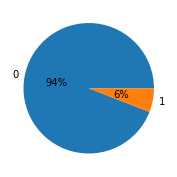

In [28]:
# Посмотрим на распределение целевого признако на всем датасете
d = data.target_action.value_counts()
plt.figure(figsize=(3,3))
plt.pie(d, labels=d.index, autopct='%1.0f%%', pctdistance=0.5)
plt.show()

Датасет сильно несбалансирован по целевому признаку.

Все нецелевые признаки - категориальные, посмотрим на количество их уникальных значений

In [29]:
data.nunique().sort_values()

target_action                  2
device_category                3
device_os                     13
utm_medium                    55
device_browser                55
device_model                 104
geo_country                  159
device_brand                 200
utm_source                   280
utm_adcontent                280
utm_campaign                 406
utm_keyword                 1192
geo_city                    2389
device_screen_resolution    4947
dtype: int64

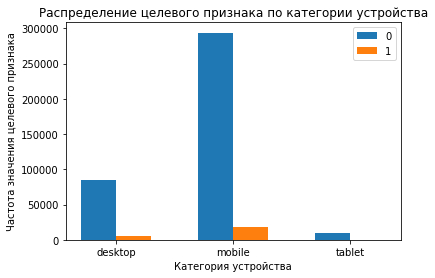

In [30]:
# Посмотрим на распределение целевого признака в зависимости от device_category
d0 = data[data.target_action==0].groupby(['device_category'], as_index=False)['target_action'].count()
d1 = data[data.target_action==1].groupby(['device_category'], as_index=False)['target_action'].count()
fig, ax = plt.subplots()
l = np.arange(len(d0.device_category))
width = 0.3
ax.bar(l-width/2, d0.target_action, width, label='0')
ax.bar(l+width/2, d1.target_action, width, label='1')
ax.set_xticks(l)
ax.set_xticklabels(d0.device_category)
ax.set_xlabel('Категория устройства')
ax.set_ylabel('Частота значения целевого признака')
ax.set_title('Распределение целевого признака по категории устройства')
ax.legend();

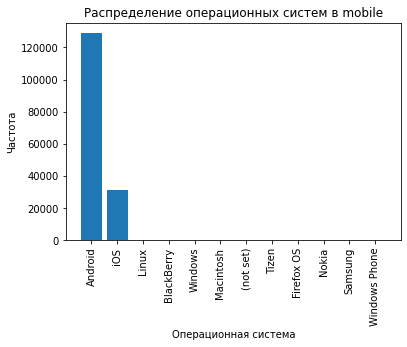

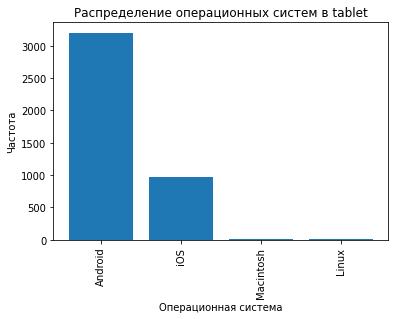

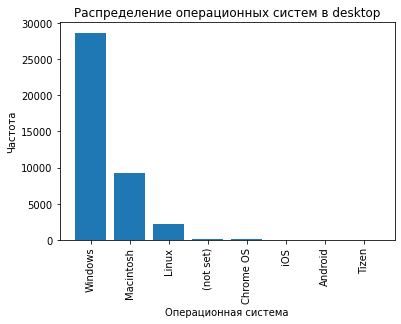

In [31]:
# Посмотрим какие операционные системы есть в категориях
for category in data.device_category.unique():
    d = data[data.device_category == category].device_os.value_counts()
    plt.bar(d.index, d)
    plt.xlabel('Операционная система')
    plt.ylabel('Частота')
    plt.title(f'Распределение операционных систем в {category}')
    plt.xticks(rotation=90)
    plt.show()

## Обработка пропусков

### Выявление пропусков во всем датасете

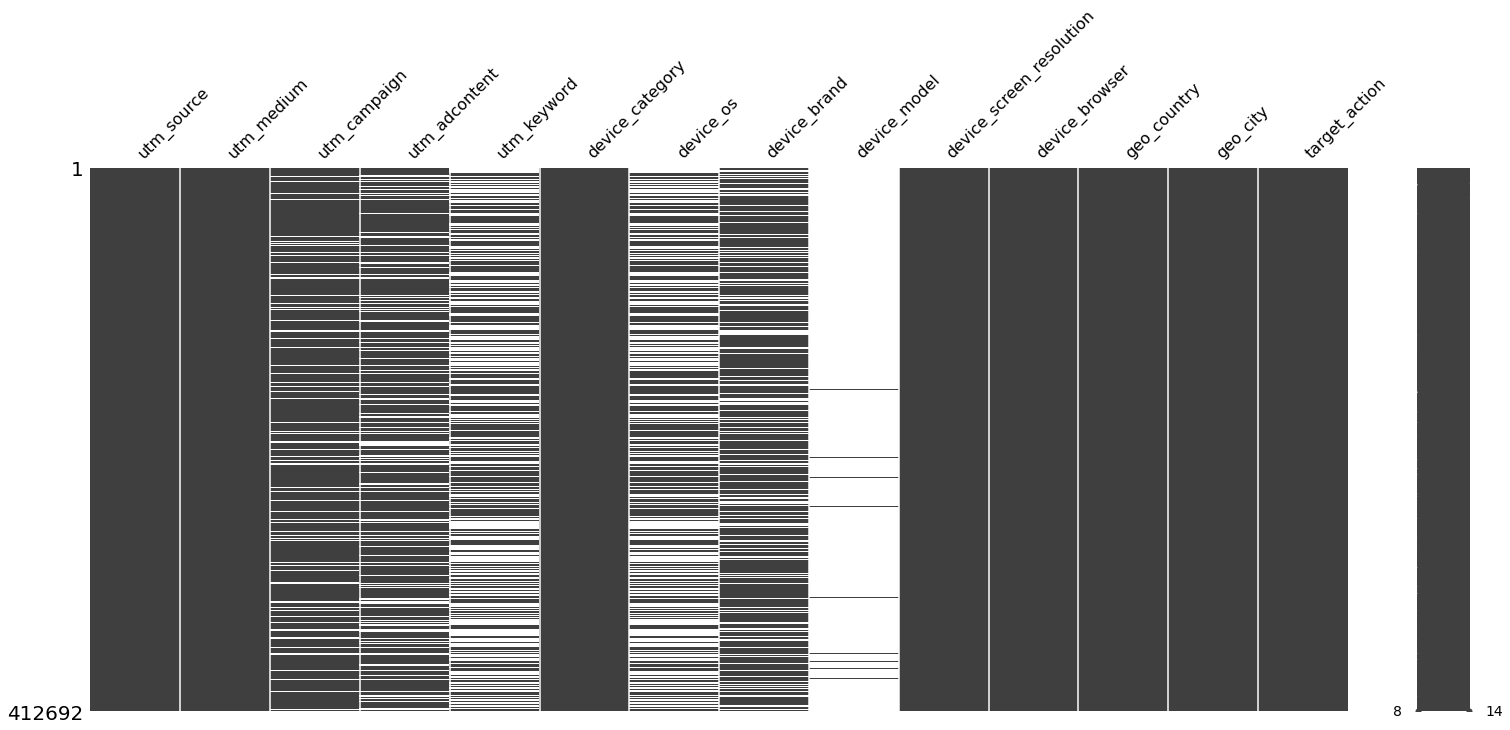

In [32]:
msno.matrix(data);

In [33]:
# Выведем процентное количество пропусков по столбцам
(data.isna().sum() / len(data) * 100).sort_values(ascending=False)

device_model                97.698041
utm_keyword                 51.017466
device_os                   50.440765
device_brand                21.808273
utm_adcontent               19.093174
utm_campaign                10.787706
utm_source                   0.009450
utm_medium                   0.000000
device_category              0.000000
device_screen_resolution     0.000000
device_browser               0.000000
geo_country                  0.000000
geo_city                     0.000000
target_action                0.000000
dtype: float64

### Обработка пропусков в device_brand

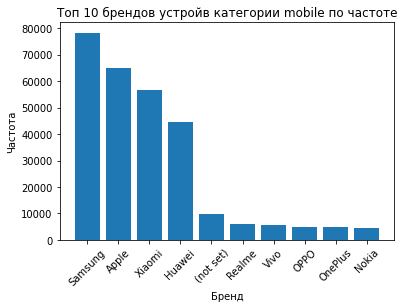

Операционные системы в строках, где нет бренда мобильного телефона:
NaN          135
Linux         24
Windows       14
Macintosh      7
Name: device_os, dtype: int64


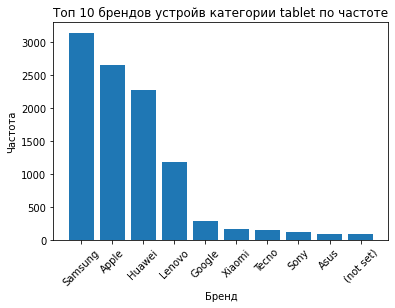

Операционные системы в строках, где нет бренда мобильного телефона:
NaN          94
Macintosh     7
Linux         6
Name: device_os, dtype: int64


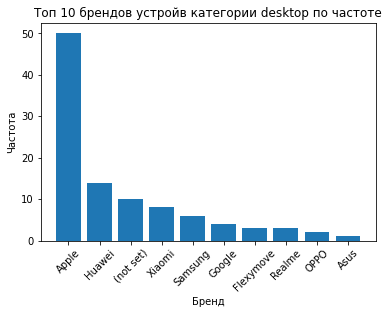

Операционные системы в строках, где нет бренда мобильного телефона:
NaN          49570
Windows      28667
Macintosh     9207
Linux         2164
(not set)       55
Chrome OS       51
Name: device_os, dtype: int64


In [34]:
# Посмотрим на распределение количества устройств по брендам для различных категорий
for category in data.device_category.unique():
    device_info = data[data.device_category == category].groupby(['device_brand'], as_index=False)['target_action'].count()
    device_info.sort_values(by='target_action', ascending=False, inplace=True)
    plt.bar(device_info.device_brand[:10], device_info.target_action[:10])
    plt.xticks(rotation=45)
    plt.xlabel('Бренд')
    plt.ylabel('Частота')
    plt.title(f'Топ 10 брендов устройв категории {category} по частоте')
    plt.show()

    print('Операционные системы в строках, где нет бренда мобильного телефона:')
    print(data[(data.device_brand.isna()) & (data.device_category == category)].device_os.value_counts(dropna=False))
del device_info

При заполнении пропусков в device_brand необходимо учитывать, что на устройствах определенного бренда могут быть только определенные операционые системы

***Стратегия обработки пропусков в device_brand:***
1. Если категория устройства mobile, то пропуски в device_brand заполняются значением Apple, если операционная система либо iOS, либо Macintosh. Остальные пропуски device_brand в данной категории заполняются значением Samsung
2. Если категория устройства tablet, то пропуски в device_brand заполняются значением Apple, если операционная система либо iOS, либо Macintosh. Остальные рпопуски device_brand в данной категории заполняются значением Samsung
3. Если категория устройства desktop, то пропуски в device_brand заполняются значением Apple, если операционная система либо nan, либо Macintosh, либо iOS. Остальные рпопуски device_brand в данной категории заполняются значением Huawei


In [35]:
# 1
ind = (data.device_brand.isna()) & (data.device_category == 'mobile') & (data.device_os.isin(['iOS', 'Macintosh']))
data.loc[ind, 'device_brand'] = 'Apple'
ind = (data.device_brand.isna()) & (data.device_category == 'mobile')
data.loc[ind, 'device_brand'] = 'Samsung'

# 2
ind = (data.device_brand.isna()) & (data.device_category == 'tablet') & (data.device_os.isin(['iOS', 'Macintosh']))
data.loc[ind, 'device_brand'] = 'Apple'
ind = (data.device_brand.isna()) & (data.device_category == 'tablet')
data.loc[ind, 'device_brand'] = 'Samsung'

# 3
ind = (data.device_brand.isna()) & (data.device_category == 'desktop')  & ((data.device_os.isna()) | (data.device_os.isin(['iOS' ,'Macintosh'])))
data.loc[ind, 'device_brand'] = 'Apple'
ind = (data.device_brand.isna()) & (data.device_category == 'desktop')
data.loc[ind, 'device_brand'] = 'Huawei'

print('Процентная доля пропусков в device_brand:', (data.device_brand.isna().sum() / len(data) * 100))

Процентная доля пропусков в device_brand: 0.0


### Обработка пропусков в device_os

***Стратегия обработки пропусков в device_os***

Будем заполнять пропуски в device_os самым частым значением в соответсвующем типе устройства и бренде устройства

In [36]:
for category in data.device_category.unique():
    for brand in data.device_brand.unique():
        indexes = (data.device_category == category) & (data.device_brand == brand)
        mode = data[indexes].device_os.mode().to_list()
        mode = mode[0] if mode else '(not set)'
        data.loc[(data.device_os.isna()) & (indexes), 'device_os'] = mode
print('Процентная доля пропусков в device_os:', (data.device_os.isna().sum() / len(data) * 100))

Процентная доля пропусков в device_os: 0.0


### Обработка пропусков в utm_ признаках

In [37]:
# Заполним все оставшиеся пропуски в utm_* знчением моды
cols = ['utm_source' ,'utm_campaign', 'utm_adcontent', 'utm_keyword']
for col in cols:
    col_mode = data[col].mode()[0]
    data[col].fillna(col_mode, inplace=True)

In [38]:
# Удалим колонку device_model, т.к. в ней 99 % пропусков
data.drop(columns=['device_model'], inplace=True)
print('Пропуски в датасете:')
(data.isna().sum() / len(data) * 100).sort_values(ascending=False)

Пропуски в датасете:


utm_source                  0.0
utm_medium                  0.0
utm_campaign                0.0
utm_adcontent               0.0
utm_keyword                 0.0
device_category             0.0
device_os                   0.0
device_brand                0.0
device_screen_resolution    0.0
device_browser              0.0
geo_country                 0.0
geo_city                    0.0
target_action               0.0
dtype: float64

# Feature Engineering

## Создание новых признаков

### Признак social_network

Создадим признка social_network, который будет говорить о том, была ли реклама в социальной сети или нет

In [39]:
social_network = ['QxAxdyPLuQMEcrdZWdWb',
                  'MvfHsxITijuriZxsqZqt',
                  'ISrKoXQCxqqYvAZICvjs',
                  'IZEXUFLARCUMynmHNBGo',
                  'PlbkrSYoHuZBWfYjYnfw',
                  'gVRrcxiDQubJiljoTbGm']
data['social_network'] = data.utm_source.apply(lambda x: int(x in social_network)).astype('object')

### Признак organic_traffic

Создадим признак is_organic_trafаic, который будет говорить о том, был ли визит органическим

In [40]:
organic_traffic = ['organic', 'referral', '(none)']
data['organic_traffic'] = data.utm_medium.apply(lambda x: int(x in organic_traffic)).astype('object')

### Признак place_name

Создадим признак place_name, который делит выборку на три группы: Moscow, Russia, Abroad

In [41]:
data.geo_country.describe()

count     412692
unique       159
top       Russia
freq      380561
Name: geo_country, dtype: object

In [42]:
def place(city, country):
    if city.lower() == 'moscow':
        return 'Moscow'
    elif country.lower() == 'russia':
        return 'Russia'
    else:
        return 'Abroad'
data['place_name'] = data.apply(lambda d: place(d.geo_city, d.geo_country), axis=1)

### Признаки geo_lat, geo_lng, geo_distance

In [43]:
# Посмотрим внимательней на признак geo_city
print(data.geo_city.describe())

count     412692
unique      2389
top       Moscow
freq       89335
Name: geo_city, dtype: object


**_Эту часть можно доработать_**

In [44]:
# Добавим долготу и широту городов
cities = pd.read_csv(f'data/my_worldcities.csv')
data = pd.merge(left=data, right=cities, how='left', on='geo_city')
data.loc[data.geo_lat.isna(), 'geo_lat'] = data.geo_lat.max()
data.loc[data.geo_lng.isna(), 'geo_lng'] = data.geo_lng.max()

# Посчитаем координаты Москвы
moscow_coords = cities[cities['geo_city']=='Moscow'][['geo_lat', 'geo_lng']].values[0]

# Добавим расстояние до Москвы
data['geo_distance'] = data.apply(lambda d: geodesic((d.geo_lat, d.geo_lng), moscow_coords).km, axis=1)

## Отбор признаков

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 412692 entries, 0 to 412691
Data columns (total 19 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   utm_source                412692 non-null  object 
 1   utm_medium                412692 non-null  object 
 2   utm_campaign              412692 non-null  object 
 3   utm_adcontent             412692 non-null  object 
 4   utm_keyword               412692 non-null  object 
 5   device_category           412692 non-null  object 
 6   device_os                 412692 non-null  object 
 7   device_brand              412692 non-null  object 
 8   device_screen_resolution  412692 non-null  object 
 9   device_browser            412692 non-null  object 
 10  geo_country               412692 non-null  object 
 11  geo_city                  412692 non-null  object 
 12  target_action             412692 non-null  int64  
 13  social_network            412692 non-null  o

In [46]:
# Выделяем целевой признак
y = data['target_action']

# Выделим нецелевые интерпретируемые признаки
X_data = data[['utm_medium',
               'device_category',
               'device_os',
               'device_brand',
               'device_screen_resolution',
               'device_browser',
               'geo_country',
               'geo_city',
               'social_network',
               'organic_traffic',
               'place_name',
               'geo_lat',
               'geo_lng',
               'geo_distance']]

Категориальные признаки будем преобразовывать с помощью OneHotEncoder, числовые признаки - с помощью StandardScaler

In [47]:
# Создаем преобразователь
preprocessor = ColumnTransformer(transformers=[
    ('numerical', StandardScaler(), make_column_selector(dtype_include=['float'])),
    ('categorical', OneHotEncoder(sparse=True, drop='first', handle_unknown='ignore'), make_column_selector(dtype_include=['object', 'int']))
])

In [48]:
# Посмотрим на метрики базовой модели Логистической регрессии
X = preprocessor.fit_transform(X_data)
logreg = LogisticRegression(random_state=42).fit(X, y)
y_pred_proba = logreg.predict_proba(X)[:, 1]
y_pred = logreg.predict(X)
print(f'roc auc score: {roc_auc_score(y, y_pred_proba)}')
print(f'accuracy score: {accuracy_score(y, y_pred)}')
print(f'precision score: {precision_score(y, y_pred)}')
print(f'recall score: {recall_score(y, y_pred)}')

roc auc score: 0.7292078083388961
accuracy score: 0.94077423356886
precision score: 0.3333333333333333
recall score: 4.091485618428051e-05


recall и precision очень низкие, это связано с сильным дисабалансом классов в целевой переменной

## Подготовка финального датасета

In [49]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y, test_size=0.3, random_state=42, stratify=y)

In [50]:
# Произведем ресемплинг для балансировки классов
X_train['target_action'] = y_train
maj_ind = X_train.target_action == 0
min_ind = X_train.target_action == 1

X_train = pd.concat(objs=[X_train[maj_ind], resample(X_train[min_ind], n_samples=maj_ind.sum(), replace=True, random_state=42)],
                    ignore_index=True)
X_train = X_train.sample(frac=1)

y_train = X_train['target_action']
X_train = X_train.drop(columns=['target_action'])

In [52]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

# Modeling

## Логистическая регрессия

In [54]:
# Тюнинг параметров модели логистической регрессии
tuning_logreg = LogisticRegression(random_state=42)
param_grid = {'C': [1, 0.1], 'solver': ['lbfgs', 'liblinear'], 'max_iter': [50, 100]}
grid_search_logreg = GridSearchCV(
    estimator=tuning_logreg,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search_logreg.fit(X_train, y_train)

bp = grid_search_logreg.best_params_
print(f'Лучшие параметры для модели логистической регресии: {bp}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры для модели логистической регресии: {'C': 1, 'max_iter': 50, 'solver': 'liblinear'}


In [55]:
# Выбор лучшей модели логистической регрессии
best_logreg = grid_search_logreg.best_estimator_
best_logreg.fit(X_train, y_train)
y_pred_logreg_proba = best_logreg.predict_proba(X_test)[:, 1]
y_pred_logreg = best_logreg.predict(X_test)

print(f'roc auc для модели логистической регрессии после тюнинга: {roc_auc_score(y_test, y_pred_logreg_proba)}')
print(f'accuracy для модели логистической регрессии после тюнинга: {accuracy_score(y_test, y_pred_logreg)}')
print(f'precision для модели логистической регрессии после тюнинга: {precision_score(y_test, y_pred_logreg)}')
print(f'recall для модели логистической регрессии после тюнинга: {recall_score(y_test, y_pred_logreg)}')

roc auc для модели логистической регрессии после тюнинга: 0.7193908392246073
accuracy для модели логистической регрессии после тюнинга: 0.6297169811320755
precision для модели логистической регрессии после тюнинга: 0.10549067813972547
recall для модели логистической регрессии после тюнинга: 0.7022640480087289


In [56]:
# Сохранение лучшей модели логистической регрессии
with open(f'models/logreg.pkl', 'wb') as file:
    dill.dump(best_logreg, file)

## Случайный лес

In [58]:
# Тюнинг параметров модели случайного леса
tuning_rfc = RandomForestClassifier(random_state=42)
param_grid = {'max_depth': [10, 20], 'n_estimators': [50, 100], 'criterion': ['gini', 'entropy']}
grid_search_rfc = GridSearchCV(
    estimator=tuning_rfc,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search_rfc.fit(X_train, y_train)

bp = grid_search_rfc.best_params_
print(f'Лучшие параметры для модели случайного леса: {bp}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры для модели случайного леса: {'criterion': 'gini', 'max_depth': 20, 'n_estimators': 100}


In [59]:
# Выбор лучшей модели случайного леса
best_rfc = grid_search_rfc.best_estimator_
best_rfc.fit(X_train, y_train)
y_pred_rfc_proba = best_rfc.predict_proba(X_test)[:, 1]
y_pred_rfc = best_rfc.predict(X_test)

print(f'roc auc для модели случайного леса после тюнинга: {roc_auc_score(y_test, y_pred_rfc_proba)}')
print(f'accuracy для модели случайного леса после тюнинга: {accuracy_score(y_test, y_pred_rfc)}')
print(f'precision для модели случайного леса после тюнинга: {precision_score(y_test, y_pred_rfc)}')
print(f'recall для модели случайного леса после тюнинга: {recall_score(y_test, y_pred_rfc)}')

roc auc для модели случайного леса после тюнинга: 0.6897355456175308
accuracy для модели случайного леса после тюнинга: 0.6590042646678729
precision для модели случайного леса после тюнинга: 0.10389226996094104
recall для модели случайного леса после тюнинга: 0.6239770867430442


In [60]:
# Сохранение лучшей модели случайного леса
with open(f'models/rfc.pkl', 'wb') as file:
    dill.dump(best_rfc, file)

## Градиентный бустинг

In [62]:
tuning_xgb = XGBClassifier(random_state=42)
param_grid = {'max_depth': [3, 5], 'n_estimators': [100, 150], 'reg_alpha': [0, 1]}
grid_search_xgb = GridSearchCV(
    estimator=tuning_xgb,
    param_grid=param_grid,
    scoring='roc_auc',
    n_jobs=-1,
    verbose=1
)
grid_search_xgb.fit(X_train, y_train)

bp = grid_search_xgb.best_params_
print(f'Лучшие параметры для модели градиентного бустинга: {bp}')

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Лучшие параметры для модели градиентного бустинга: {'max_depth': 5, 'n_estimators': 150, 'reg_alpha': 1}


In [63]:
# Выбор лучшей модели градиентного бустинга
best_xgb = grid_search_xgb.best_estimator_
best_xgb.fit(X_train, y_train)
y_pred_xgb_proba = best_xgb.predict_proba(X_test)[:, 1]
y_pred_xgb = best_xgb.predict(X_test)

print(f'roc auc для градиентного бустинга после тюнинга: {roc_auc_score(y_test, y_pred_xgb_proba)}')
print(f'accuracy для градиентного бустинга после тюнинга: {accuracy_score(y_test, y_pred_xgb)}')
print(f'precision для градиентного бустинга после тюнинга: {precision_score(y_test, y_pred_xgb)}')
print(f'recall для градиентного бустинга после тюнинга: {recall_score(y_test, y_pred_xgb)}')

roc auc для градиентного бустинга после тюнинга: 0.7212889436075722
accuracy для градиентного бустинга после тюнинга: 0.6488110622899974
precision для градиентного бустинга после тюнинга: 0.10880481364443098
recall для градиентного бустинга после тюнинга: 0.6856246590289143


In [64]:
# Сохранение модели градиентного бустинга
with open(f'models/xgb.pkl', 'wb') as file:
    dill.dump(best_xgb, file)

## Многослойный персептрон

In [65]:
base_mlp = MLPClassifier(random_state=42, early_stopping=True)
base_mlp.fit(X_train, y_train)

MLPClassifier(early_stopping=True, random_state=42)

In [66]:
y_pred_mlp_proba = base_mlp.predict_proba(X_test)[:, 1]
y_pred_mlp = base_mlp.predict(X_test)
print(f'roc auc для модели: {roc_auc_score(y_test, y_pred_mlp_proba)}')
print(f'accuracy для модели: {accuracy_score(y_test, y_pred_mlp)}')
print(f'precision для модели: {precision_score(y_test, y_pred_mlp)}')
print(f'recall для модели: {recall_score(y_test, y_pred_mlp)}')

roc auc для модели: 0.6693648235956422
accuracy для модели: 0.7303405272680279
precision для модели: 0.10672020287404903
recall для модели: 0.48213311511183854


In [67]:
# Сохранение модели многослойного персептрона
with open(f'models/mlp.pkl', 'wb') as file:
    dill.dump(base_mlp, file)

Модель градиентного бустинга дает лучшие результаты предсказания совершения целевого действия. Значения ее метрик превышают аналогичные, полученные для модели логистической регрессии, модели случайного леса и модели многослойного персептрона. 